In [1]:
# Install yfinance untuk mengambil data saham
!pip install yfinance --upgrade --no-cache-dir

# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf


In [2]:
# Download stock data of Telkom Indonesia (TLKM.JK)
telkom_data = yf.download('TLKM.JK', start='2010-01-01', end='2024-01-01')

# Tampilkan 5 baris pertama dari dataset
telkom_data.head()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TLKM.JK,TLKM.JK,TLKM.JK,TLKM.JK,TLKM.JK,TLKM.JK
Date,,,,,,
2010-01-04 00:00:00+00:00,1144.864136,1910.0,1920.0,1890.0,1910.0,44820000
2010-01-05 00:00:00+00:00,1150.858398,1920.0,1930.0,1910.0,1920.0,56250000
2010-01-06 00:00:00+00:00,1138.870361,1900.0,1940.0,1890.0,1900.0,67870000
2010-01-07 00:00:00+00:00,1108.900024,1850.0,1900.0,1850.0,1850.0,145440000
2010-01-08 00:00:00+00:00,1120.888062,1870.0,1890.0,1840.0,1870.0,88070000


In [3]:
# Cek apakah ada nilai yang hilang dalam dataset
print(telkom_data.isnull().sum())

# Jika ada nilai NaN, kita hapus baris yang mengandung nilai tersebut
telkom_data = telkom_data.dropna()

# Pastikan dataset sekarang bersih
print(telkom_data.isnull().sum())


Price      Ticker 
Adj Close  TLKM.JK    0
Close      TLKM.JK    0
High       TLKM.JK    0
Low        TLKM.JK    0
Open       TLKM.JK    0
Volume     TLKM.JK    0
dtype: int64
Price      Ticker 
Adj Close  TLKM.JK    0
Close      TLKM.JK    0
High       TLKM.JK    0
Low        TLKM.JK    0
Open       TLKM.JK    0
Volume     TLKM.JK    0
dtype: int64


In [15]:
# Tampilkan statistik deskriptif dari dataset
statistics = telkom_data.describe()
print(statistics)


Price     Adj Close        Close         High          Low         Open  \
Ticker      TLKM.JK      TLKM.JK      TLKM.JK      TLKM.JK      TLKM.JK   
count   3463.000000  3463.000000  3463.000000  3463.000000  3463.000000   
mean    2408.191820  3086.309558  3120.033208  3052.909327  3086.319954   
std      967.027161  1006.470844  1014.217173   998.413627  1006.478124   
min      821.072876  1320.000000  1360.000000  1320.000000  1320.000000   
25%     1497.870911  2170.000000  2212.500000  2140.000000  2170.000000   
50%     2632.897949  3295.000000  3340.000000  3250.000000  3300.000000   
75%     3184.001953  3950.000000  3980.000000  3910.000000  3950.000000   
max     4295.701172  4800.000000  4850.000000  4780.000000  4850.000000   

Price         Volume  
Ticker       TLKM.JK  
count   3.463000e+03  
mean    9.886707e+07  
std     6.388555e+07  
min     0.000000e+00  
25%     6.132145e+07  
50%     8.492820e+07  
75%     1.190732e+08  
max     1.155861e+09  


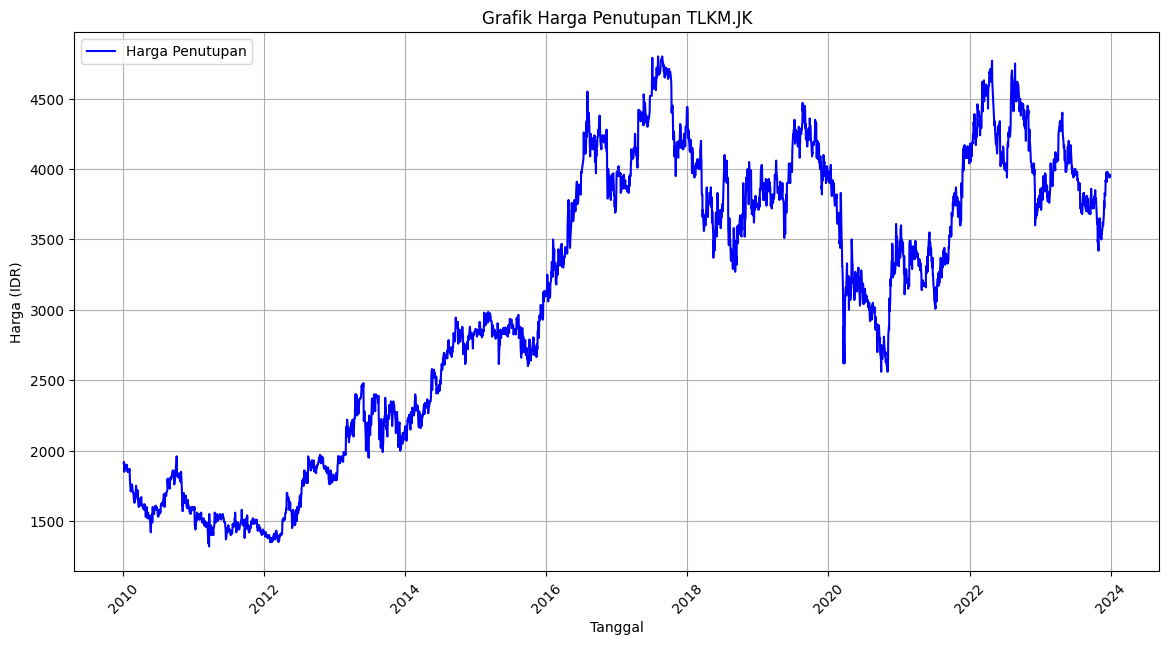

In [16]:
import matplotlib.pyplot as plt

# Membuat grafik harga penutupan
plt.figure(figsize=(14, 7))
plt.plot(telkom_data.index, telkom_data['Close'], label='Harga Penutupan', color='blue')
plt.title('Grafik Harga Penutupan TLKM.JK')
plt.xlabel('Tanggal')
plt.ylabel('Harga (IDR)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


In [17]:
# Mengambil harga penutupan
data = telkom_data['Close'].values.reshape(-1, 1)

# Normalisasi data (opsional, tergantung pada model yang digunakan)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


In [18]:
# Membagi data menjadi 80% untuk pelatihan dan 20% untuk pengujian
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_size]
test_data = scaled_data[train_size:len(scaled_data)]


In [21]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Tentukan langkah waktu
time_step = 60  # Menggunakan 60 hari sebelumnya untuk memprediksi hari berikutnya

# Buat dataset
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Ubah bentuk input menjadi [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [20]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [22]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))  # Lapisan output

# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# Melatih model
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.0433
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 9.2849e-04
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 8.7183e-04
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 8.5952e-04
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 7.6692e-04
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 8.2610e-04
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 8.0098e-04
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 7.9371e-04
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 7.2808e-04
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 7.5195e-04
Epoch 11/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 6.8799e-04
Epoch 12/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 6.9046e-04
Epoch 13/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 6.2890e-04
Epoch 14/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 7.5197e-04
Epoch 15/50
85/85 ━

In [24]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


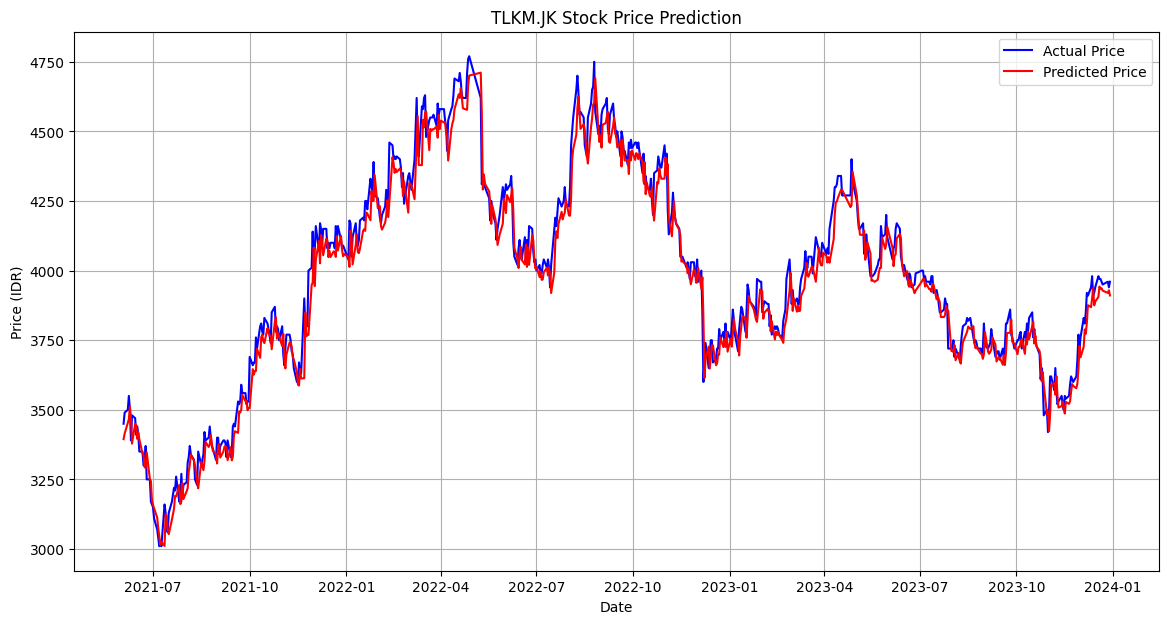

In [25]:
# Visualize the results
plt.figure(figsize=(14, 7))
plt.plot(telkom_data.index[train_size + time_step + 1:], y_test_inverse, label='Actual Price', color='blue')
plt.plot(telkom_data.index[train_size + time_step + 1:], y_pred_inverse, label='Predicted Price', color='red')
plt.title('TLKM.JK Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (IDR)')
plt.legend()
plt.grid()
plt.show()


In [28]:
# Predicting future prices
last_data = scaled_data[-time_step:].reshape(1, time_step, 1)
future_prediction = model.predict(last_data)
future_prediction_inverse = scaler.inverse_transform(future_prediction)

print(f'Predicted closing price for the next day: {future_prediction_inverse[0][0]:.2f} IDR')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted closing price for the next day: 3919.79 IDR


### **Analisis Model**

1. **Model**: Model yang saya gunakan adalah Long Short-Term Memory (LSTM) yang mampu menangani data time series dengan baik. Model ini menggunakan dua layer LSTM dan beberapa unit Dense untuk memprediksi harga saham Telkom Indonesia.

2. **Dataset**: Dataset yang digunakan adalah harga penutupan saham Telkom Indonesia (TLKM.JK) dari tahun 2010 hingga 2024 yang diambil dari Yahoo Finance.

3. **Hasil**: Grafik di atas menunjukkan bahwa prediksi harga saham Telkom mendekati harga aktual, walaupun terdapat sedikit perbedaan. Model LSTM ini cukup baik untuk memprediksi harga saham dalam jangka pendek, meskipun hasilnya bisa ditingkatkan dengan jumlah data lebih banyak atau tuning hyperparameter lebih lanjut.


